# Language Model: Autocomplete

### Table of Content
#### [1. Load and Preprocess Data](#load)
#### [2. Develope N-gram Based Language Model](#ngram)
#### [3. Perplexity](#prep)
#### [4. Build an Autocomplete System](#auto)





In [1]:
import random
import numpy as np
import math
import pandas as pd
import nltk
nltk.data.path.append('.')
nltk.download('punkt')


## Load and Preprocess Data

### Loading Data

In [11]:
with open("en_US.twitter.txt",encoding="utf8") as f:
    data = f.read()


In [12]:
print(f" Data type: {type(data)}")
print(f" Number of letters: {len(data)}")
print(f" First 200 letters: {data[0:200]}")

 Data type: <class 'str'>
 Number of letters: 3335477
 First 200 letters: How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.
When you meet someone special... you'll know. Your heart will beat more rapidly and you'll


### Pre-process Data
- Split data using "\n"
- Split each sentence into words
- Split data into train and test dataset
- Find word counts
- Replace words that appears less than N times by <unk>

In [13]:
def split_to_sentences(data):
    """
    Spliting data by linebreak
    Args:
        data: str
    Returns:
        A list of sentences
    """
    sentences = data.split("\n")
    sentences = [s.strip() for s in sentences]
    sentences = [s for s in sentences if len(s) > 0]
    return sentences

In [23]:
def tokenize_sentences(sentences):
    """
    Tokenize sentences into tokens(words)
    Args:
        sentences: List of strings
    Returns:
        List of lists of tokens
    """
    tokenize_sentences = []

    for sentence in sentences:
        sentence = sentence.lower()
        tokenize = nltk.word_tokenize(sentence)
        tokenize_sentences.append(tokenize)
    return tokenize_sentences

In [25]:
sentences = split_to_sentences(data)
tokenized_data = tokenize_sentences(sentences)

In [27]:
random.seed(87)
random.shuffle(tokenized_data)
train_size = int(len(tokenized_data) * 0.8)
train_data = tokenized_data[0:train_size]
test_data = tokenized_data[train_size:]

In [28]:
f"Total letters: {len(tokenized_data)},Train data letters: {len(train_data)}, Test data letters: {len(test_data)}"

'Total letters: 47961,Train data letters: 38368, Test data letters: 9593'

### Count Words Dictionary

In [30]:
def count_words(tokenize_sentences):
    """
    Count number of words in tokenized sentences
    Args:
        tokenize_sentences: List of lists of words
    Returns:
        A dictionary that maps word to the freq
    """
    word_counts = {}

    for sentence in tokenize_sentences:
        for word in sentence:
            word_counts[word] = word_counts.get(word, 0) +1

    return word_counts

### Out of Vocabulary(OOV) Words

- Create a list of the most frequent words in the training set, called the closed vocabulary .
- Convert all the other words that are not part of the closed vocabulary to the token 'unk'.

In [32]:
def get_words_with_nplus_freq(tokenize_sentences, count_threshold):

    """
    Looking for words with N appearance or more.
    Args:
        tokenized_sentences: List of lists of sentences
        count_threshold: minimum number of occurrences for a word to be in the closed vocabulary.
    Returns:
        List of Words that appear N times or more
    """

    closed_vocab = []
    word_counts = count_words(tokenize_sentences)

    for word,cnt in word_counts.items():
        if cnt>= count_threshold:
            closed_vocab.append(word)
    return closed_vocab

In [35]:
def replace_oov_words(tokenize_sentences, vocabulary, unknown_token = "<unk>"):
    """
    Replace words not in the vocabulary with unknown_token.
    Args:
        tokenized_sentences: List of lists of strings
        vocabulary: List of strings that we will use
        unknown_token: A string representing OOV words
    """

    vocabulary = set(vocabulary)
    replaced_tokenized_sentences = []
    for sentece in tokenize_sentences:
        replaced_sentence = []
        for word in sentece:
            if word in vocabulary:
                replaced_sentence.append(word)
            else:
                replaced_sentence.append(unknown_token)
        replaced_tokenized_sentences.append(replaced_sentence)
    
    return replaced_tokenized_sentences

In [37]:
def preprocess(train_data, test_data, count_threshold):
    """
    Pre-process data
    Args:
        train_data, test_data: List of lists of strings.
        count_threshold: minimum number of occurrences for a word to be in the closed vocabulary.
    Returns:
        Tuple of (
        - pre-process training data
        - pre-process test data
        - Vocabulary that appears n times or more in training data
        )
    """
    vocabulary = get_words_with_nplus_freq(train_data, count_threshold)
    train_data_replaced = replace_oov_words(train_data, vocabulary)
    test_data_replaced = replace_oov_words(test_data, vocabulary)
    return train_data_replaced, test_data_replaced, vocabulary



In [40]:
minimum_freq = 2
train_data_processed, test_data_processed, vocabulary = preprocess(train_data, 
                                                                        test_data, 
                                                                        minimum_freq)

## Develope N-gram Based Language Model

In [45]:
def count_ngram(data, n, start_token = "<s>", end_token = "<e>"):
    """
    Count n-grams in data
    Args:
        data: List of list of words.
        n: number of words in a sequence.
    Returns:
        A dictionary woth tuple of n-words as keys and freq as values.
    """
    n_gram_dict = {}

    for sentence in data:
        sentence = [start_token]*n + sentence + [end_token]

        sentence = tuple(sentence)
        if n==1:
            m = len(sentence)
        else:
            m = len(sentence)-1
        
        for i in range(m):
            ngram = sentence[i:i+n]
            n_gram_dict[ngram] = n_gram_dict.get(ngram, 0) +1
    return n_gram_dict


### Estimate Probability Using K-smoothing

In [47]:
def estimate_probability(word, previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=1):
    """
    Estimate the probability of next word using ngram and k-smoothing
    Args:
        word: next word
        previous_n_gram: A sequence of words of length n
        n_gram_counts: Dictionary of counts of (n+1)-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary_size: number of words in the vocabulary
        k: positive constant, smoothing parameter
    Returns:
        Probability of word
    """

    previous_n_gram = tuple(previous_n_gram)
    previous_n_gram_count = n_gram_counts[previous_n_gram] if previous_n_gram in n_gram_counts  else 0
    denominator = previous_n_gram_count + k * vocabulary_size
    n_plus1_gram = previous_n_gram + (word,)
    n_plus1_gram_count = n_plus1_gram_counts[n_plus1_gram] if n_plus1_gram in n_plus1_gram_counts  else 0
    numerator = n_plus1_gram_count + k 
    probability = numerator/denominator
    return probability


- The function below calculates probabilities for all possible words.

In [54]:
def estimate_probabilities(previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary, k=1):
    
    previous_n_gram = tuple(previous_n_gram)
    vocabulary = vocabulary + ["<unk>", "<e>"]
    vocabulary_size = len(vocabulary)
    probabilities = {}
    for word in vocabulary:
        probability = estimate_probability(word, previous_n_gram, n_gram_counts, 
        n_plus1_gram_counts, vocabulary_size, k=k)
        probabilities[word] = probability
    return probabilities

### Count and Probability Matrices

In [69]:
def make_count_matrix(n_plus1_gram_counts, vocabulary):

    vocabulary = vocabulary + ["<e>", "<unk>"]
    n_grams = []
    for nplus1_gram in n_plus1_gram_counts.keys():
        ngram = nplus1_gram[:-1]
        n_grams.append(ngram)
    n_grams = list(set(n_grams))

    row_index = {ngram:i for i,ngram in enumerate(n_grams)}
    col_index = {word:j for j,word in enumerate(vocabulary)}

    nrows = len(n_grams)
    ncols = len(vocabulary)
    count_matrix = np.zeros((nrows, ncols))

    for nplus1_gram, count in n_plus1_gram_counts.items():
        ngram = nplus1_gram[:-1]
        word = nplus1_gram[-1]
        if word not in vocabulary:
            continue
        i = row_index[ngram]
        j = col_index[word]
        count_matrix[i,j] = count
    count_matrix = pd.DataFrame(count_matrix, index = n_grams, columns = vocabulary)
    return count_matrix

In [72]:
def make_probability_matrix(n_plus1_gram_counts, vocabulary, k):
    count_matrix = make_count_matrix(n_plus1_gram_counts, unique_words)
    count_matrix += k
    prob_matrix = count_matrix.div(count_matrix.sum(axis = 1), axis = 0)
    return prob_matrix

## Perplexity

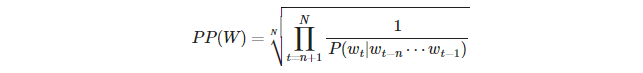

In [79]:
def calculate_perplexity(sentence, n_gram_counts, nplus1_gram_counts, vocabulary_size, k = 1):
    """
    Calculate perplexity for list of sentences
    Args:
        sentence: List of strings
        n_gram_counts: Dictionary of counts of (n+1)-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary_size: number of unique words in the vocabulary
        k: Positive smoothing constant
    Returns:
        perplexity score
    """
    #length of previous words
    n = len(list(n_gram_counts.keys())[0])
    sentence = ["<s>"] + sentence + ["<e>"]
    sentence = tuple(sentence)
    N = len(sentence)
    product = 1

    for t in range(n, N):
        ngram = sentence[t-n:t]
        word = sentence[t]
        probability = estimate_probability(word,ngram, n_gram_counts, nplus1_gram_counts, len(unique_words), k=1)
        product *= 1/probability
    
    perplexity = product**(1/float(N))
    return perplexity



## Build an Auto-complete System

In [88]:
def suggest_a_word(previous_tokens, n_gram_counts, n_plus1_gram_counts, vocabulary, k=1.0, start_with=None):
    """
    Suggest the next word
    Args:
        previous_tokens: The sentence you input where each token is a word. Must have length > n 
        n_gram_counts: Dictionary of counts of (n+1)-grams
        n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
        vocabulary: List of words
        k: positive constant, smoothing parameter
        start_with: If not None, specifies the first few letters of the next word
        
    Returns:
        A tuple of 
          - string of the most likely next word
          - corresponding probability
    """
    #length of previous words
    n = len(list(n_gram_counts.keys())[0])
    previous_n_gram = previous_tokens[-n:]
    probabilities = estimate_probabilities(previous_n_gram,
                                           n_gram_counts, n_plus1_gram_counts,
                                           vocabulary, k=k)
    suggestions = None
    max_prob = 0
    for word, prob in probabilities.items():
        if start_with != None:
            if not word.startswith(start_with):
                continue
        if prob> max_prob:
            suggestion = word
            max_prob = prob
    
    return suggestion, max_prob


In [89]:
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_ngram(sentences, 1)
bigram_counts = count_ngram(sentences, 2)

previous_tokens = ["i", "like"]
tmp_suggest1 = suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0)
print(f"The previous words are 'i like',\n\tand the suggested word is `{tmp_suggest1[0]}` with a probability of {tmp_suggest1[1]:.4f}")

print()
tmp_starts_with = 'c'
tmp_suggest2 = suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0, start_with=tmp_starts_with)
print(f"The previous words are 'i like', the suggestion must start with `{tmp_starts_with}`\n\tand the suggested word is `{tmp_suggest2[0]}` with a probability of {tmp_suggest2[1]:.4f}")

The previous words are 'i like',
	and the suggested word is `a` with a probability of 0.2727

The previous words are 'i like', the suggestion must start with `c`
	and the suggested word is `cat` with a probability of 0.0909


### Get Multiple Suggestions

In [91]:
def get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0, start_with=None):
        model_counts = len(n_gram_counts_list)
        suggestions = []
        for i in range(model_counts-1):
            ngram_counts = n_gram_counts_list[i]
            n_plus1_gram_counts = n_gram_counts_list[i+1]
            suggestion = suggest_a_word(previous_tokens, ngram_counts,
                                    n_plus1_gram_counts, vocabulary,
                                    k=k, start_with=start_with)
            suggestions.append(suggestion)
        return suggestions

In [93]:
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_ngram(sentences, 1)
bigram_counts = count_ngram(sentences, 2)
trigram_counts = count_ngram(sentences, 3)
quadgram_counts = count_ngram(sentences, 4)
qintgram_counts = count_ngram(sentences, 5)

n_gram_counts_list = [unigram_counts, bigram_counts, trigram_counts, quadgram_counts, qintgram_counts]
previous_tokens = ["i", "like"]
tmp_suggest3 = get_suggestions(previous_tokens, n_gram_counts_list, unique_words, k=1.0)

print(f"The previous words are 'i like', the suggestions are:")
display(tmp_suggest3)

The previous words are 'i like', the suggestions are:


[('a', 0.2727272727272727),
 ('a', 0.2),
 ('a', 0.1111111111111111),
 ('a', 0.1111111111111111)]

In [95]:
n_gram_counts_list = []
for n in range(1, 6):
    print("Computing n-gram counts with n =", n, "...")
    n_model_counts = count_ngram(train_data_processed, n)
    n_gram_counts_list.append(n_model_counts)

Computing n-gram counts with n = 1 ...
Computing n-gram counts with n = 2 ...
Computing n-gram counts with n = 3 ...
Computing n-gram counts with n = 4 ...
Computing n-gram counts with n = 5 ...


In [96]:
previous_tokens = ["i", "am", "to"]
tmp_suggest4 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest4)

The previous words are ['i', 'am', 'to'], the suggestions are:


[('be', 0.02766367370678687),
 ('have', 0.00013485267345425124),
 ('have', 0.00013488905375328792),
 ('i', 6.745362563237774e-05)]

In [97]:
previous_tokens = ["i", "want", "to", "go"]
tmp_suggest5 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest5)

The previous words are ['i', 'want', 'to', 'go'], the suggestions are:


[('to', 0.014050206069689023),
 ('to', 0.004697320542507443),
 ('to', 0.0009423167530457024),
 ('to', 0.00040439441935701285)]

In [98]:
previous_tokens = ["hey", "how", "are"]
tmp_suggest6 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0)

print(f"The previous words are {previous_tokens}, the suggestions are:")
display(tmp_suggest6)

The previous words are ['hey', 'how', 'are'], the suggestions are:


[('you', 0.023424142254644932),
 ('you', 0.0035589578297072254),
 ('you', 0.00013489815189531904),
 ('i', 6.745362563237774e-05)]